## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

from keras.applications.vgg19 import VGG19

Using plaidml.keras.backend backend.


In [3]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [5]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [4]:
def crop_random_shape_from_image(image: np.ndarray, cutter_shape: tuple = (200,200), verbose: bool = False) -> np.ndarray:
    '''Crop a randomly placed cutter_shape sized box from given image and returns it'''
    if(verbose):
        print(image.shape)
        print(cutter_shape)

    shape = image.shape

    if(cutter_shape[0] > shape[0] or cutter_shape[1] > shape[1]):
        raise ValueError("Cutter shape ", cutter_shape, " larger than one or more dimensions of given picture shape", shape[:2])
    
    x_1 = np.random.randint(0, shape[0] - cutter_shape[0])
    x_2 = x_1 + cutter_shape[0]

    y_1 = np.random.randint(0, shape[1] - cutter_shape[1])
    y_2 = y_1 + cutter_shape[1]

    if(verbose):
        print(x_1, x_2, y_1, y_2)
    
    result = image[x_1:x_2, y_1:y_2]
    
    return result

def overlay_transparent(background, overlay, x = 0, y = 0):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        raise ValueError("UwU")

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        raise ValueError("Not transparent")

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:]

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [5]:
from keras.applications.vgg19 import preprocess_input #required to format input

class Background_source:
    def load_images(self):
        for img in os.listdir(self.path):
            img = cv2.imread(os.path.join(self.path, img))
            if(img is not None):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.background_images.append(img)
    
    def __init__(self, directory_path:str, crop_shape:tuple=(200,200), blur_kernel:tuple=(3,3)):
        self.path = directory_path
        self.crop_shape = crop_shape
        self.blur_kernel = blur_kernel
        self.background_images = []

        self.load_images()
    
    def apply_background(self, image):
        background = crop_random_shape_from_image(self.background_images[np.random.randint(len(self.background_images))], self.crop_shape)
        background = cv2.blur(background, self.blur_kernel)
        background = np.asarray(background, np.float32)
        background = background[:,:] / 255

        result = overlay_transparent(background, image / 255)

        result = result * 255

        return result
    
    def apply_background_preprocess_input(self, image):
        image = self.apply_background(image)
        image = preprocess_input(image)

        alpha = np.ones(image.shape[:2])
        image = np.dstack((image, alpha)).astype(np.float32)

        return image

In [6]:
from keras.preprocessing.image import ImageDataGenerator

bg = Background_source("../../background_images", (200,200), (3,3))

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.6,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = bg.apply_background_preprocess_input
)
validation_datagen = ImageDataGenerator(
    preprocessing_function = bg.apply_background_preprocess_input
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode='categorical')

C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\tensorflow\python\framework

Found 26875 images belonging to 25 classes.
Found 11525 images belonging to 25 classes.


In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Input
from keras.models import Model

def remove_alpha(image):
    return image[:,:,:,:-1]

new_input = Input(shape=(200,200,4))
lam = Lambda(remove_alpha, output_shape=(200,200,3))(new_input)
temp = Model(inputs=new_input, outputs=lam)

base_model = VGG19(weights='imagenet', include_top=False, input_tensor=temp.output)

#freeze layers for first time training
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024)(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512)(top_model)
top_model = Dense(len(train_generator.class_indices), activation="softmax")(top_model)

model = Model(inputs = base_model.inputs, outputs = top_model)

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 4)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
__________

In [8]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model_vertical.png", show_shapes = True)
plot_model(model, to_file="model/model_horizontal.png", show_shapes = True, rankdir="LR")

In [9]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from datetime import datetime

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=12,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=4,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

#https://keras.io/guides/writing_your_own_callbacks/
class timeCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _time = datetime.now()
        print(_time.strftime("%H:%M:%S"))

callbacks = [checkpoint, tensorboard, csvlogger, reduceLR, earlystop, timeCallback()]

C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [10]:
from keras.optimizers import Adam

opt = Adam(lr=1e-3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


history = model.fit_generator(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/100
840/840 [==============================] - 1041s 1s/step - loss: 63.0828 - acc: 0.4317 - val_loss: 19.6540 - val_acc: 0.5972

Epoch 00001: val_loss improved from inf to 19.65404, saving model to ./base.model
19:28:07
Epoch 2/100
840/840 [==============================] - 886s 1s/step - loss: 19.6201 - acc: 0.5029 - val_loss: 14.9090 - val_acc: 0.4915

Epoch 00002: val_loss improved from 19.65404 to 14.90903, saving model to ./base.model
19:42:55
Epoch 3/100
840/840 [==============================] - 887s 1s/step - loss: 16.9163 - acc: 0.4999 - val_loss: 15.8587 - val_acc: 0.5155

Epoch 00003: val_loss did not improve from 14.90903
19:57:41
Epoch 4/100
840/840 [==============================] - 888s 1s/step - loss: 19.7122 - acc: 0.4867 - val_loss: 19.1847 - val_acc: 0.5539

Epoch 00004: val_loss did not improve from 14.90903
20:12:29
Epoch 5/100
840/840 [==============================] - 886s 1s/step - loss: 24.7969 - acc: 0.4838 - val_loss: 21.6217 - val_acc: 0.5545

Epoch

In [10]:
json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")
#model.load_weights("./model/lego_weights.h5")

In [11]:
import matplotlib.pyplot as plt

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

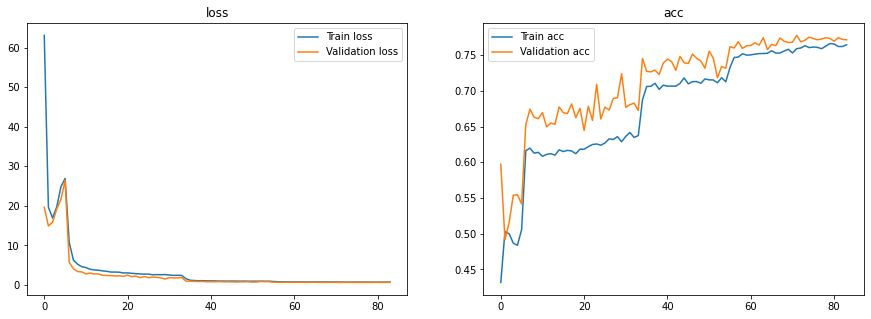

In [12]:
show_final_history(history)

In [13]:
#fine tune by unlocking training for only last conv block and using a low learning rate
for layer in base_model.layers[:-5]:
    layer.trainable = True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 4)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
__________

C:\Users\Anto\anaconda3\envs\LEGO\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [14]:
opt = Adam(lr=1e-6)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

#train again
history = model.fit_generator(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 10, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/10


INFO:plaidml:Analyzing Ops: 140 of 646 operations complete


355/840 [===========>..................] - ETA: 28:12 - loss: 0.6584 - acc: 0.7784

INFO:plaidml:Analyzing Ops: 187 of 647 operations complete


840/840 [==============================] - 3256s 4s/step - loss: 0.6210 - acc: 0.7918 - val_loss: 0.5533 - val_acc: 0.7957

Epoch 00001: val_loss improved from 0.62321 to 0.55327, saving model to ./base.model
16:48:09
Epoch 2/10
840/840 [==============================] - 3222s 4s/step - loss: 0.5484 - acc: 0.8135 - val_loss: 0.5622 - val_acc: 0.7944

Epoch 00002: val_loss did not improve from 0.55327
17:41:51
Epoch 3/10
840/840 [==============================] - 3176s 4s/step - loss: 0.5057 - acc: 0.8272 - val_loss: 0.5452 - val_acc: 0.7974

Epoch 00003: val_loss improved from 0.55327 to 0.54524, saving model to ./base.model
18:34:50
Epoch 4/10
840/840 [==============================] - 3215s 4s/step - loss: 0.4739 - acc: 0.8373 - val_loss: 0.4938 - val_acc: 0.8194

Epoch 00004: val_loss improved from 0.54524 to 0.49382, saving model to ./base.model
19:28:29
Epoch 5/10
840/840 [==============================] - 3196s 4s/step - loss: 0.4480 - acc: 0.8460 - val_loss: 0.4719 - val_acc: 0.

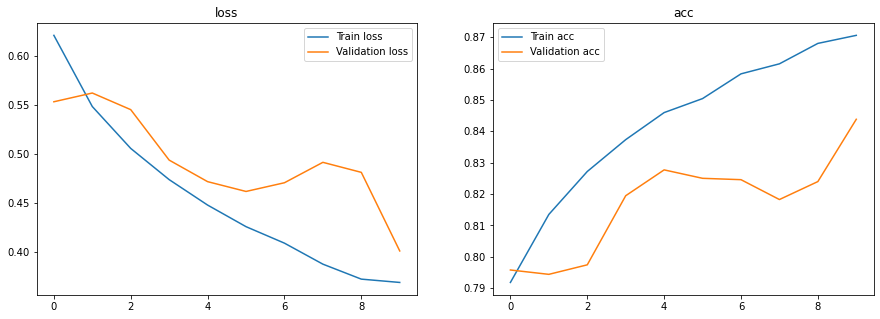

In [15]:
show_final_history(history)

We can try and test the model on random new images

In [17]:
import cv2

image_path = "../../LEGO_brick_custom/3298 roof tile 2x3/3298_6_20.png"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = bg.apply_background_preprocess_input(image) #before testing we have to convert the image
image = np.expand_dims(image, axis=0)

prediction = loaded_model.predict(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 4)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
__________

ValueError: Not transparent

In [26]:
print(prediction[0])
print(prediction[0].tolist().index(max(prediction[0])))
print(list(validation_generator.class_indices.keys())[prediction[0].tolist().index(max(prediction[0]))])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 6.0771525e-28 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
16
3298 roof tile 2x3
